In [1]:
import numpy as np
import os
import struct
from array import array
import random
from tqdm import tqdm
from matplotlib import pyplot as plt

np.random.seed(0)

## Custom classes
I import required modules implemented using `numpy`. You can check `README.md` for detailed description of each module.

In [2]:
from ne_torch import Linear, ReLU, Softmax, MSELoss

## Data
Read MNIST dataset with the code I stole from this [Kaggle notebook](https://www.kaggle.com/code/hojjatk/read-mnist-dataset).

In [3]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        

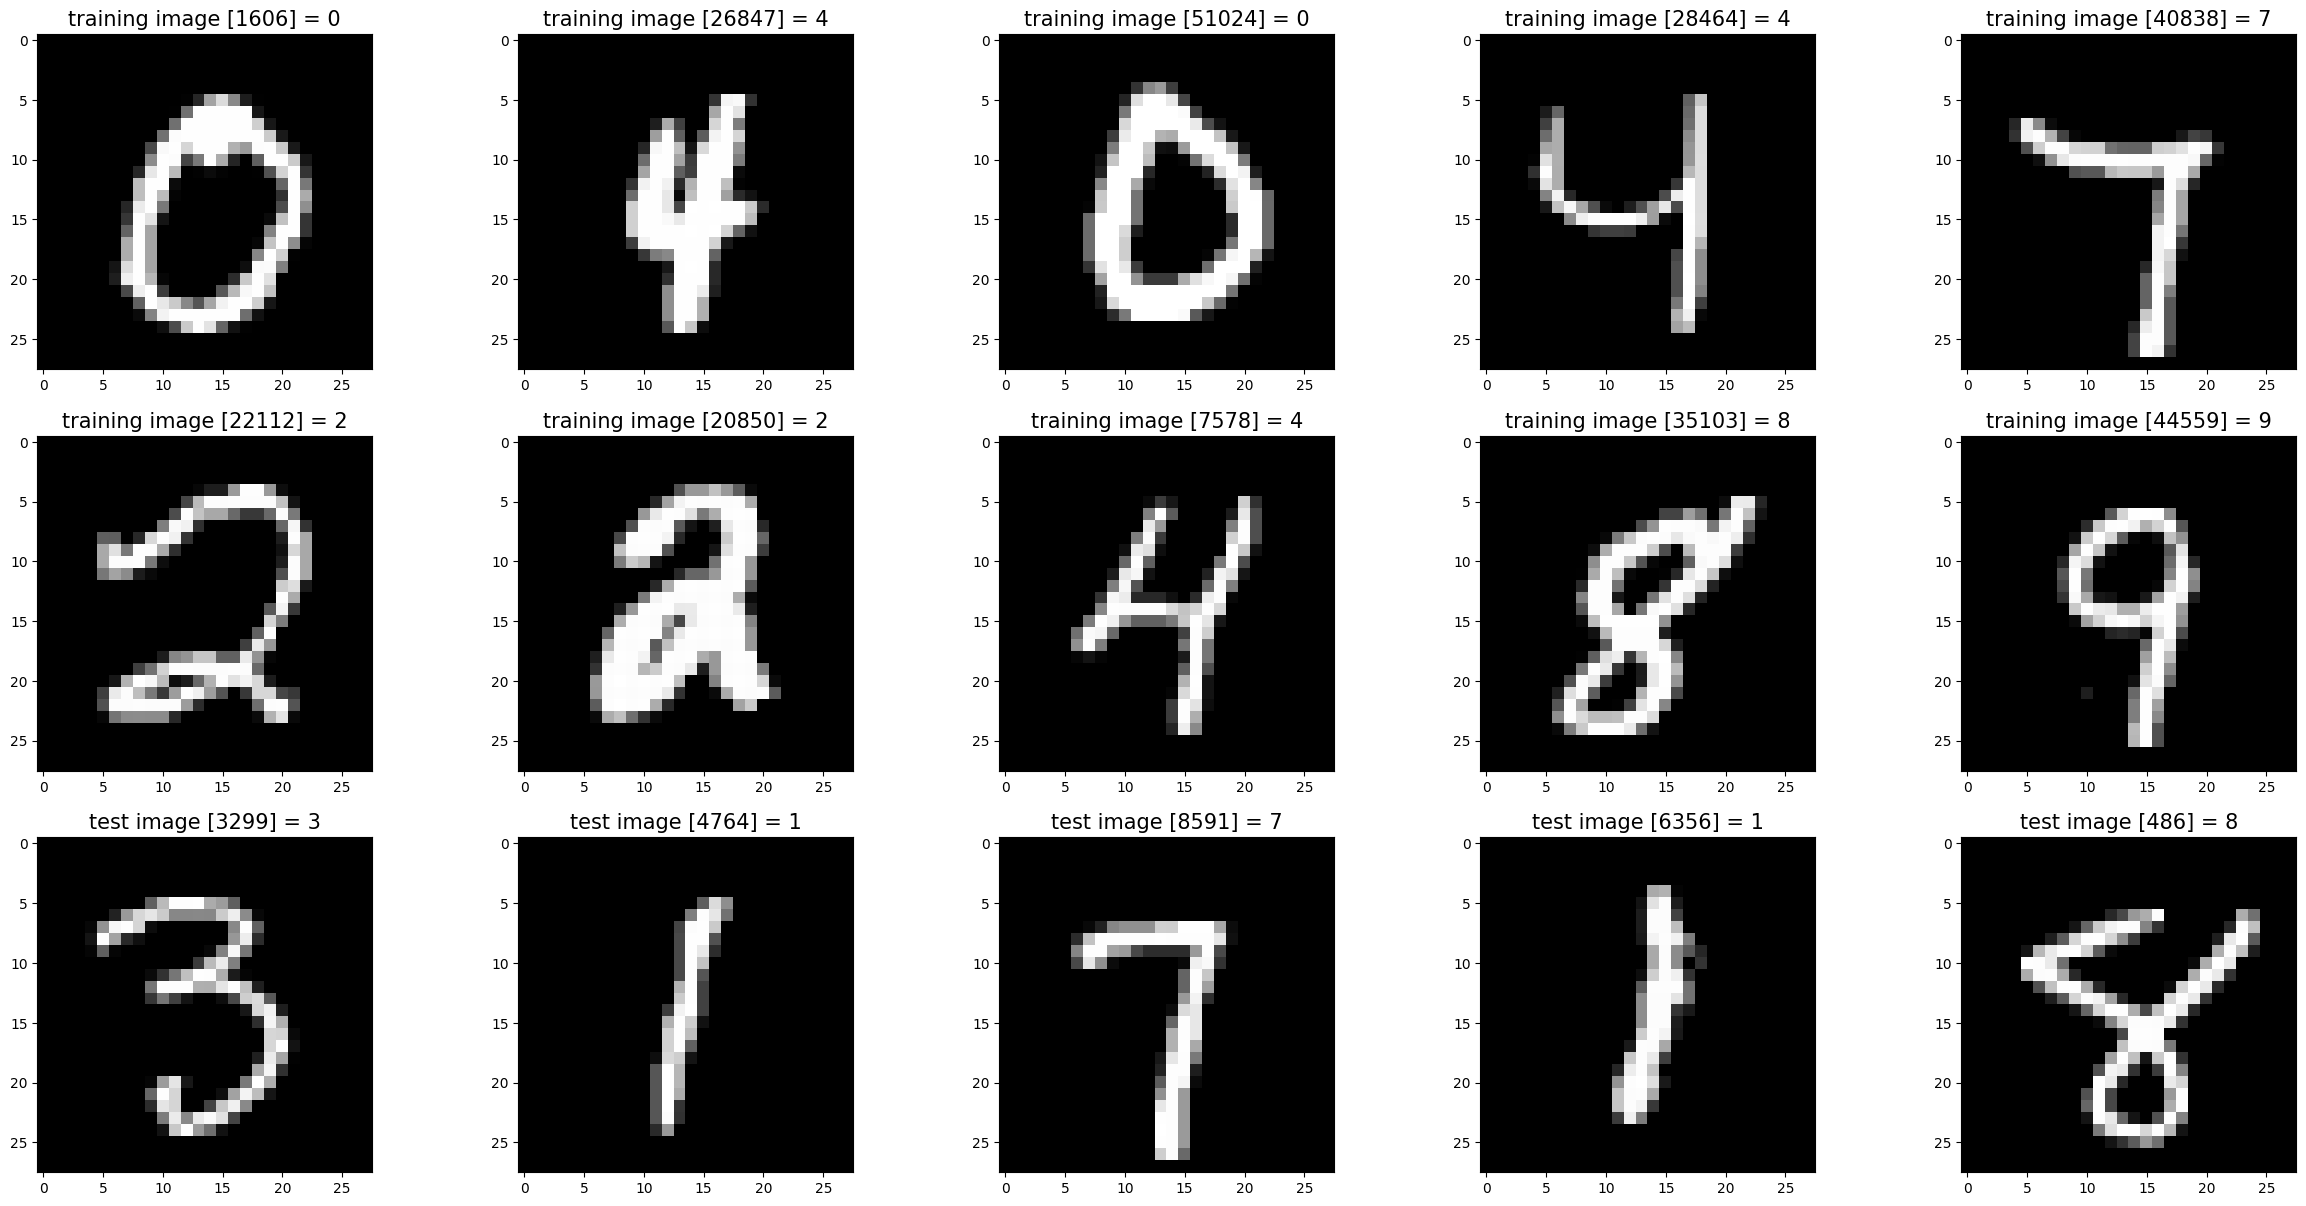

In [4]:
#
# Set file paths based on added MNIST Datasets
#
input_path = './MNIST'
training_images_filepath = os.path.join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = os.path.join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = os.path.join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

## Model architecture

Create a simple neural network architecture using custom classes:
- Linear
- Relu
- Softmax

Network contain only two linear fully connected layers and single ReLu activation between.

In [5]:
class SimpleMLP:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.fc1 = Linear(input_dim, hidden_dim)
        self.relu = ReLU()
        self.fc2 = Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu.forward(x)
        x = self.fc2.forward(x)
        return x

    def backward(self, grad_out):
        grad = self.fc2.backward(grad_out)
        grad = self.relu.backward(grad)
        grad = self.fc1.backward(grad)
        return grad

    def step(self, lr):
        self.fc1.step(lr)
        self.fc2.step(lr)

## Training Loop

This section explains the training loop used for a simple fully-connected neural network implemented without autograd.


The training loop performs the standard sequence of operations for each epoch:

1. **Shuffle the dataset**  
   Ensures the model does not learn patterns from the order of samples.

2. **Mini-batch iteration**  
   The dataset is split into batches. Each batch is forwarded, backpropagated, and used to update parameters.

3. **Forward pass**  
   The model processes a batch of inputs and produces predictions (logits).

4. **Loss computation**  
   The loss function compares predictions with targets and produces a scalar loss value.

5. **Backward pass**  
   The loss function produces gradients for the final layer, and the model backpropagates them through each layer.

6. **Parameter update**  
   Each layer applies its gradient update using simple SGD with a chosen learning rate.

7. **Epoch summary**  
   After all batches are processed, the epoch loss is printed.


**Summary**

This loop implements the minimal training procedure for a neural network without frameworks:
- manual forward
- manual loss
- manual backward
- manual parameter updates

In [6]:
def train(model: SimpleMLP, X, y_onehot, epochs=10, lr=0.01, effective_batch_size=64):
    loss_fn = MSELoss()
    n_samples = X.shape[0]

    for epoch in range(epochs):
        # Shuffle the data
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y_onehot[indices]

        for start in tqdm(range(0, n_samples, effective_batch_size)):
            end = start + effective_batch_size
            x_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Forward
            logits = model.forward(x_batch)
            loss = loss_fn.forward(logits, y_batch)

            # Backward
            grad_loss = loss_fn.backward()
            model.backward(grad_loss)

            # Update
            model.step(lr)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")


## Evaluation Loop

The evaluation loop measures model performance on unseen data without updating any weights.

1. Run a full forward pass of the model on the input dataset.
2. Apply `Softmax` to convert raw logits into class probabilities.
3. Select the class with the highest probability for each sample.
4. Compare predicted labels with ground-truth labels.
5. Compute accuracy as the fraction of correct predictions.

This loop does not perform backward propagation or parameter updates. It is used only to assess how well the trained model generalizes.


In [7]:
def evaluate(model, X, y):
    act = Softmax()
    logits = model.forward(X)
    probs = act.forward(logits)
    preds = np.argmax(probs, axis=1)
    accuracy = (preds == y).mean()
    return accuracy


## Model Training

Prepare train/test data and convert to appropreate formats

In [8]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Flatten images and normalize
x_train = x_train.reshape(x_train.shape[0], -1).astype(np.float32) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1).astype(np.float32) / 255.0

num_classes = 10
num_features = x_train.shape[1]

# For MSELoss, convert labels to one-hot
y_train_onehot = np.zeros((y_train.shape[0], num_classes), dtype=np.float32)
y_train_onehot[np.arange(y_train.shape[0]), y_train] = 1.0

y_test_onehot = np.zeros((y_test.shape[0], num_classes), dtype=np.float32)
y_test_onehot[np.arange(y_test.shape[0]), y_test] = 1.0

We configure the model hyperparameters, train it on MNIST, and measure how well it performs on both the training and test set.  
Since MNIST test data comes from the same distribution as the training set (same domain), using a very small batch size (such as `batch_size = 2`) intentionally adds noise to gradient updates.  
This noise can help the model escape shallow minima and acts as an additional regularization effect, which may slightly improve generalization on the test set.

In [9]:
hidden_dim = 128
lr = 0.05
epochs = 10
batch_size = 2

model = SimpleMLP(num_features, hidden_dim, num_classes)

train(model, x_train, y_train_onehot, epochs=epochs, lr=lr, effective_batch_size=batch_size)
train_acc = evaluate(model, x_train, y_train)
test_acc = evaluate(model, x_test, y_test)

print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")


100%|██████████| 30000/30000 [00:10<00:00, 2835.07it/s]


Epoch 1/10, Loss: 0.0168


100%|██████████| 30000/30000 [00:10<00:00, 2740.75it/s]


Epoch 2/10, Loss: 0.0075


100%|██████████| 30000/30000 [00:20<00:00, 1456.94it/s]


Epoch 3/10, Loss: 0.0053


100%|██████████| 30000/30000 [00:15<00:00, 1967.39it/s]


Epoch 4/10, Loss: 0.0097


100%|██████████| 30000/30000 [00:09<00:00, 3094.16it/s]


Epoch 5/10, Loss: 0.0108


100%|██████████| 30000/30000 [00:09<00:00, 3048.51it/s]


Epoch 6/10, Loss: 0.0015


100%|██████████| 30000/30000 [00:09<00:00, 3065.53it/s]


Epoch 7/10, Loss: 0.0270


100%|██████████| 30000/30000 [00:10<00:00, 2945.23it/s]


Epoch 8/10, Loss: 0.0015


100%|██████████| 30000/30000 [00:09<00:00, 3059.12it/s]


Epoch 9/10, Loss: 0.0248


100%|██████████| 30000/30000 [00:09<00:00, 3138.54it/s]


Epoch 10/10, Loss: 0.0176
Train Accuracy: 97.98%
Test Accuracy: 97.13%


## Visualization

Visualization of some random images for both models

In [12]:
def visualize_predictions_grid(nn, X, y, n_rows=5, n_cols=10):
    """
    Visualize predictions in a grid.

    nn: trained DeepMLP
    X: test images, shape (num_samples, 28*28)
    y: test labels, shape (num_samples,)
    n_rows: number of rows to display
    n_cols: number of columns to display
    """
    total_samples = n_rows * n_cols
    np.random.seed(22)
    indices = np.random.choice(len(X), total_samples, replace=False)
    x_vis = X[indices]
    y_true = y[indices]

    act = Softmax()
    logits = nn.forward(x_vis)
    probs = act.forward(logits)
    y_pred = np.argmax(probs, axis=1)

    plt.figure(figsize=(n_cols*1.5, n_rows*2))
    for i in range(total_samples):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(x_vis[i].reshape(28,28), cmap='gray')
        plt.axis('off')
        plt.title(f"GT: {y_true[i]}\nPred: {y_pred[i]}", fontsize=9)
    plt.tight_layout()
    plt.show()

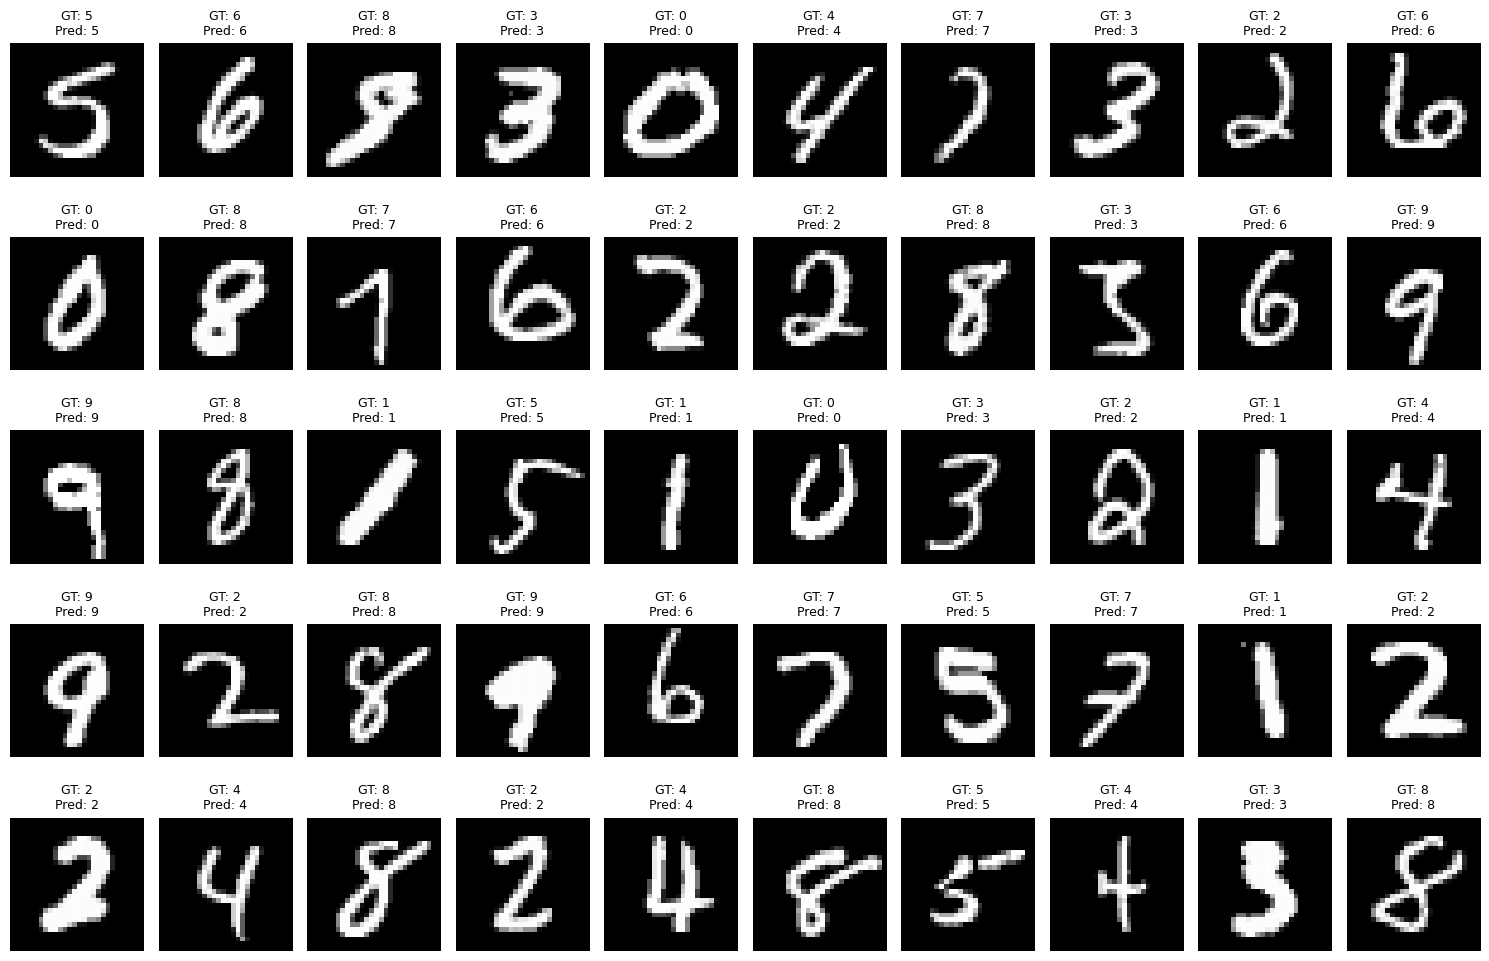

In [13]:
visualize_predictions_grid(model, x_test, y_test, n_rows=5, n_cols=10)